In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('insta_data.csv')


In [ ]:
df.columns = df.columns.str.strip()

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = text.strip().lower()
    return text

df['Post Description'] = df['Post Description'].astype(str).apply(clean_text)

label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}


df['Sentiment'] = df['Sentiment'].astype(str).str.strip().str.lower().map(label_map)

df = df.dropna(subset=['Sentiment'])
df['Sentiment'] = df['Sentiment'].astype(int)

pd.set_option('display.max_columns', None)

df.head()


,PostID,Post Description,Date,Language Code,Full Language,Sentiment
0,B___bDEHMD8,दश म 24 घट म 127 मत और 3277 नए कस करन क मरज क ...,05/10/2020,hi,Hindi,0
1,B__0_uQgk04,in the last 24 hours 128 deaths 1511 discharge...,05/10/2020,en,English,2
2,B__0154DdKr,करनश लढणयच kj पटरन \n\n \n\nfightagainstcorona...,05/10/2020,kn,Kannada,0
3,B__0pLylisj,swahiliforummediaupdates \ncoronavirusupdates ...,05/10/2020,sw,Swahili,1
4,B__1Gt5qI74,mrs chaitali chavarkar misses being at home es...,05/10/2020,en,English,2


<ipython-input-17-ccf082e2cb4a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=sentiment_counts.values, palette='Set2')


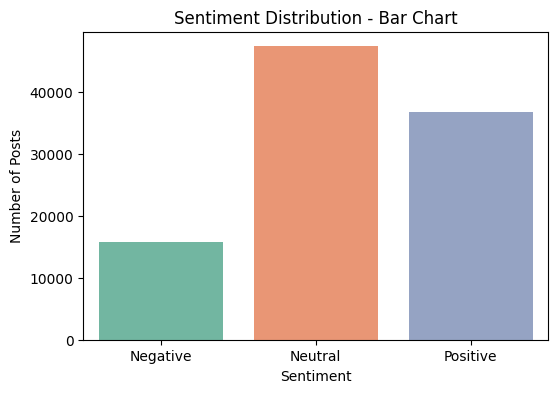

In [ ]:

sentiment_counts = df['Sentiment'].value_counts().sort_index()
label_names = ['Negative', 'Neutral', 'Positive']


plt.figure(figsize=(6, 4))
sns.barplot(x=label_names, y=sentiment_counts.values, palette='Set2')
plt.title('Sentiment Distribution - Bar Chart')
plt.ylabel('Number of Posts')
plt.xlabel('Sentiment')
plt.show()


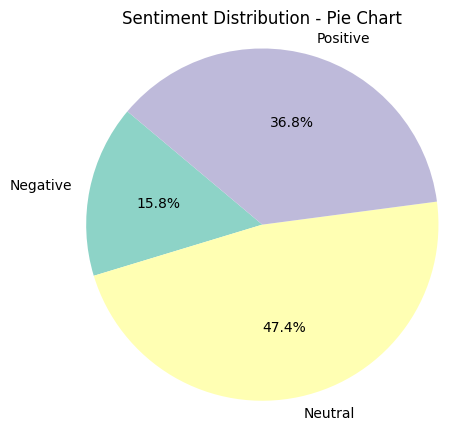

In [ ]:

plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts.values, labels=label_names, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
plt.title('Sentiment Distribution - Pie Chart')
plt.axis('equal')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

texts = df['Post Description'].values
labels = df['Sentiment'].values


X_train, X_test, y_train, y_test = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")


Train size: 80000
Test size: 20001


In [ ]:
!pip install transformers datasets -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12=

In [ ]:
from transformers import XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

train_encodings = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=128
)

test_encodings = tokenizer(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=128

    )


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
import torch

class InstaSentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


train_dataset = InstaSentimentDataset(train_encodings, y_train)
test_dataset = InstaSentimentDataset(test_encodings, y_test)


In [ ]:

import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    save_total_limit=2,
    push_to_hub=False
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    acc = accuracy_score(labels, preds) * 100
    f1 = f1_score(labels, preds, average='macro') * 100

    return {
        'accuracy': round(acc, 2),
        'f1': round(f1, 2)
    }


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    save_total_limit=2,
    push_to_hub=False
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
from transformers import Trainer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=3) # 3 for negative, neutral, positive


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-26-0af58ef3ba1b>:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.312100,0.268134,90.690000,88.280000
2,0.259300,0.266924,91.970000,89.930000
3,0.174300,0.329798,91.660000,89.800000
4,0.145400,0.312726,93.020000,91.280000
5,0.136000,0.324157,93.280000,91.610000
6,0.087800,0.382569,93.270000,91.600000


TrainOutput(global_step=30000, training_loss=0.20654581583340964, metrics={'train_runtime': 14037.8218, 'train_samples_per_second': 34.193, 'train_steps_per_second': 2.137, 'total_flos': 3.157361012736e+16, 'train_loss': 0.20654581583340964, 'epoch': 6.0})

In [ ]:
eval_results = trainer.evaluate()

print(f"\n Final Test Accuracy: {eval_results['eval_accuracy']:.2f}%")
print(f" Final F1 Score (Macro): {eval_results['eval_f1']:.2f}%")



 Final Test Accuracy: 93.28%
 Final F1 Score (Macro): 91.61%


In [ ]:
from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print("\nClassification Report:\n", report)



Classification Report:
               precision    recall  f1-score   support

    Negative       0.85      0.85      0.85      3161
     Neutral       0.96      0.94      0.95      9480
    Positive       0.93      0.96      0.95      7360

    accuracy                           0.93     20001
   macro avg       0.92      0.92      0.92     20001
weighted avg       0.93      0.93      0.93     20001



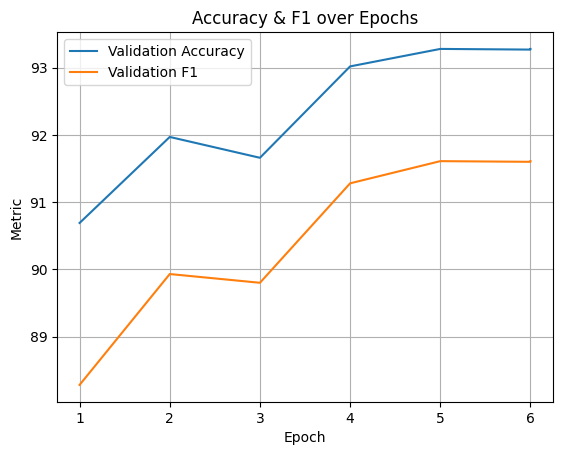

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)
logs = logs.dropna(subset=['eval_accuracy'])

plt.plot(logs['epoch'], logs['eval_accuracy'], label='Validation Accuracy')
plt.plot(logs['epoch'], logs['eval_f1'], label='Validation F1')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Accuracy & F1 over Epochs")
plt.legend()
plt.grid(True)
plt.show()


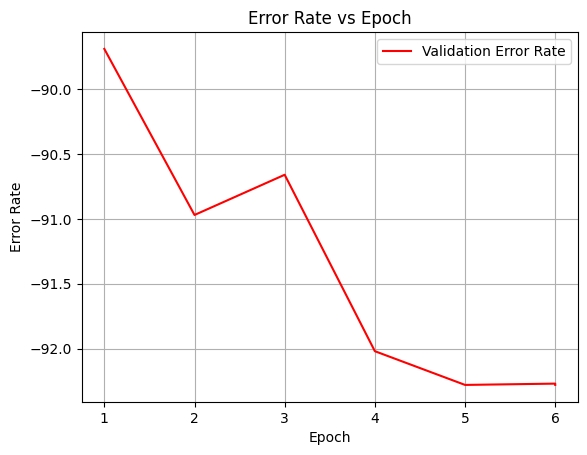

In [ ]:
logs['error_rate'] = 1 - logs['eval_accuracy']

plt.plot(logs['epoch'], logs['error_rate'], label='Validation Error Rate', color='red')
plt.xlabel("Epoch")
plt.ylabel("Error Rate")
plt.title("Error Rate vs Epoch")
plt.grid(True)
plt.legend()
plt.show()


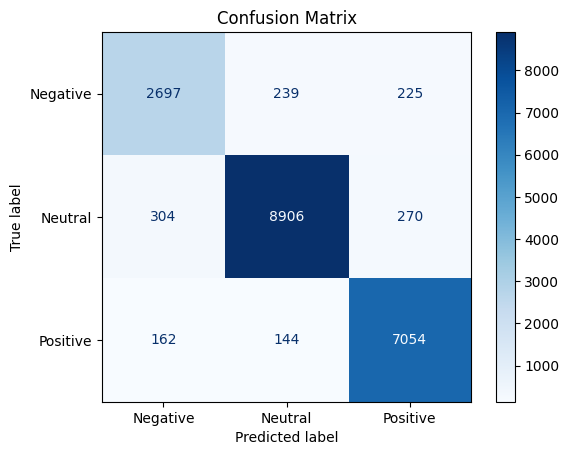

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


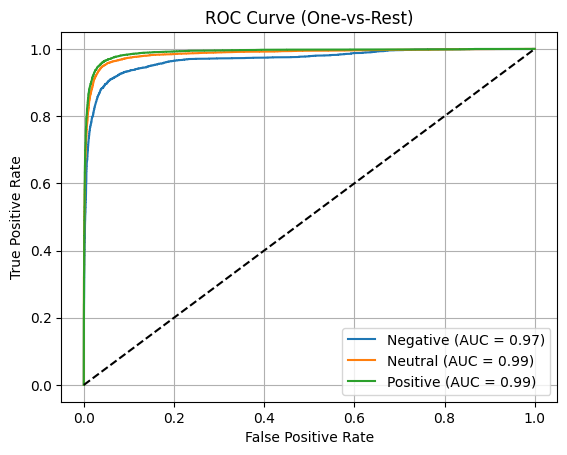

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

y_test_bin = label_binarize(y_true, classes=[0, 1, 2])
y_score = predictions.predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

sensitivity = recall_score(y_true, y_pred, average=None)

specificity = []
cm = confusion_matrix(y_true, y_pred)
for i in range(3):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

precision = precision_score(y_true, y_pred, average=None)
fmajor = f1_score(y_true, y_pred, average='macro')

for i, cls in enumerate(['Negative', 'Neutral', 'Positive']):
    print(f"\nClass: {cls}")
    print(f"  Precision   : {precision[i]:.2f}")
    print(f"  Sensitivity : {sensitivity[i]:.2f}")
    print(f"  Specificity : {specificity[i]:.2f}")

print(f"\nFmajor (Macro F1): {fmajor:.2f}")



Class: Negative
  Precision   : 0.85
  Sensitivity : 0.85
  Specificity : 0.97

Class: Neutral
  Precision   : 0.96
  Sensitivity : 0.94
  Specificity : 0.96

Class: Positive
  Precision   : 0.93
  Sensitivity : 0.96
  Specificity : 0.96

Fmajor (Macro F1): 0.92
